# 02. Neural Network classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options).

Book version of this notebook - https://www.learnpytorch.io/02_pytorch_classification/

All other resources - https://github.com/mrdbourke/pytorch-deep-learning

## 1. Make classification data and get it ready

In [2]:
import sklearn

In [3]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [4]:
len(X), len(y)

(1000, 1000)

In [5]:
print(f"First 5 samples of X: {X[:5]}")
print(f"First 5 samples of y: {y[:5]}")

First 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: [1 1 1 1 0]


In [6]:
# Make a DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label" : y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


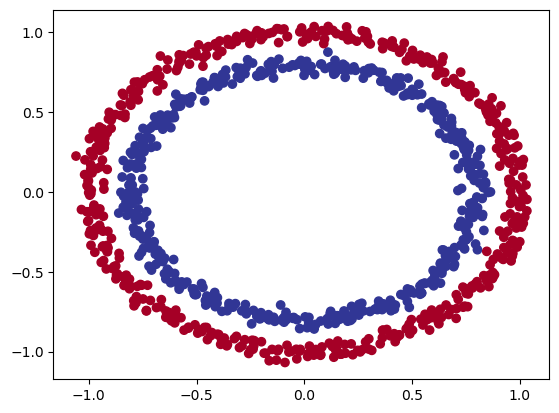

In [7]:
# Visualize the data
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

Note: the data we're working with is often referred to as toy dataset, a dataset that is small enough to experiment with but still sizeable enough to ptarctice the fundamentals.

### 1.1 Check input and output shapes

In [8]:
X.shape, y.shape

((1000, 2), (1000,))

In [9]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values of one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")


Values of one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [10]:
import torch
torch.__version__

'1.13.1'

In [11]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [12]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [13]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code
2. Constructa model (by subclassing `nn.Module`)
3. define a loss function and optimizer
4. Create a training and test loop

In [15]:
# Inport PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Now we've set up device agnostic code, let's create a model that:

1. Subclasses `nn.Module`
2. Create 2 `nn.Linear()` layers that are capable of hadling the shapes of our data
3. Defines a `forward()` method that outlines the forward pass of the model
4. Instantiate an instance of our model class and send to the target device

In [16]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling the shape of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    # 3. Define a forward method that outlines the forward pass
    def forward(self, x):
        return self.layer2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output
    
# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [18]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.4147, -0.5671],
                      [ 0.5986,  0.4356],
                      [-0.5058,  0.5300],
                      [ 0.4467,  0.3571],
                      [-0.6578,  0.5321]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.0990, -0.2540,  0.2344,  0.1077,  0.0503], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.3874, -0.3104,  0.3593, -0.0580, -0.1841]], device='cuda:0')),
             ('1.bias', tensor([0.1625], device='cuda:0'))])

In [20]:
# Make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[ 0.3175],
        [ 0.0699],
        [ 0.7418],
        [ 0.1983],
        [ 0.3847],
        [ 0.2363],
        [-0.1781],
        [-0.1400],
        [ 0.7563],
        [ 0.0493]], device='cuda:0')

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

Which loss function or optimzer should you use?

This is problem specific.

For example, for regression you might want MAE or MSE (mean absolute error or mean squared error).

For classification you might want binary cross entropy or categorical cross entropy (cross entropy).

As a reminder, the loss function measures how wrong your model's predictions are.

And for optimizers, two of the most common are SGD and Adam.

* For some common chaoices of loss functions and optimizers - https://www.learnpytorch.io/02_pytorch_classification/#21-setup-loss-function-and-optimizer
* For the loss function we're going to use `torch.nn.BCEWithLogitsLoss`. for more on what binary cross entropy (BCE) see https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a
* For defintion of what a logit is in deep learning - https://stackoverflow.com/a/52111173/7900723
* For different optimizers see `torch.optim`

In [21]:
# Setup loss function
loss_fn = nn.BCEWithLogitsLoss()  # BCELoss() with the sigmoid activation function built-in

# Setup an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [22]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

## 3. Train model

To train a model, we're going to need to build a training loop with the following steps:

1. Forward pass
2. Calculate the loss
3. optimizer zero grad
4. Loss backward (backpropogation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**.

We can convert these **logits** into **prediction probabilities** by passing them into some kind of activation function (eg. sigmoid for binary cross entropy and softmax for multiclass classification).

The we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`.

In [23]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.3175],
        [0.0699],
        [0.7418],
        [0.1983],
        [0.3847]], device='cuda:0')

In [24]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5787],
        [0.5175],
        [0.6774],
        [0.5494],
        [0.5950]], device='cuda:0')

For our prediction probablity values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=0` (class 0)

In [25]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0')

In [26]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2 Building a training and test loop

In [27]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put model to target device
model_0.to(device)

# Put data to the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train) # nn.BCEWithLogitsLoss expects raw logits as input
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate test loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
    

Epoch: 0 | Loss: 0.72425, Acc: 53.62% | Test loss: 0.70843, Test acc: 53.50%
Epoch: 10 | Loss: 0.71049, Acc: 53.50% | Test loss: 0.69867, Test acc: 52.00%
Epoch: 20 | Loss: 0.70351, Acc: 52.25% | Test loss: 0.69430, Test acc: 52.00%
Epoch: 30 | Loss: 0.69969, Acc: 51.50% | Test loss: 0.69234, Test acc: 52.00%
Epoch: 40 | Loss: 0.69746, Acc: 51.62% | Test loss: 0.69151, Test acc: 52.00%
Epoch: 50 | Loss: 0.69608, Acc: 50.38% | Test loss: 0.69125, Test acc: 52.00%
Epoch: 60 | Loss: 0.69518, Acc: 50.25% | Test loss: 0.69127, Test acc: 53.50%
Epoch: 70 | Loss: 0.69457, Acc: 49.88% | Test loss: 0.69142, Test acc: 53.00%
Epoch: 80 | Loss: 0.69415, Acc: 49.75% | Test loss: 0.69165, Test acc: 51.50%
Epoch: 90 | Loss: 0.69385, Acc: 49.75% | Test loss: 0.69190, Test acc: 52.00%


## 4. Make predictions and evaluate the model

From the metrics it looks like our model is not learning anything.

So to inspect it let's make some predictions and visualize.

To do so, we're going to import a function called `plot_decision_boundary()` - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

In [28]:
import requests
from pathlib import Path

# Download helper function from Learn PyTorch repo (if it's not lready downloaded)
if Path("helper_functions.py").is_file():
    print("help_functions.py already exists, skipping download")
else:
        print("Downloading helper_functions.py")
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        with open("helper_functions.py", "wb") as f:
              f.write(request.content)
from helper_functions import plot_predictions, plot_decision_boundary


help_functions.py already exists, skipping download


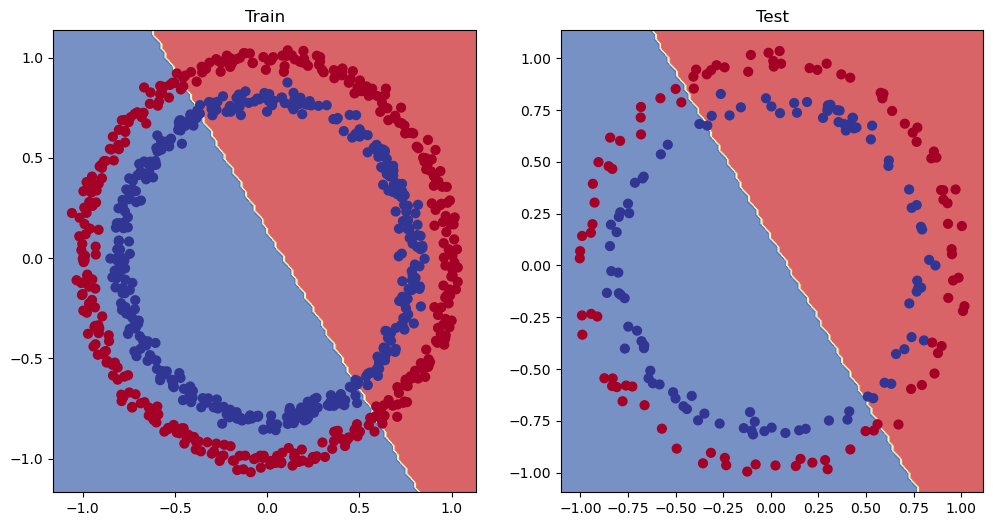

In [29]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perseoctive)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

These are all from a model's perspective because they deal directly with the model rather than the data.

And because these options are all values we can change, they are referred to as **hyperparameters**.

Let's try and improve our model by:
* Adding more hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs: 100 -> 1000

In [30]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))
    
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [31]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [32]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put model to target device
model_1.to(device)

# Put data to the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_1.train()

    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train) # nn.BCEWithLogitsLoss expects raw logits as input
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate test loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Acc: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Acc: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Acc: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Acc: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%


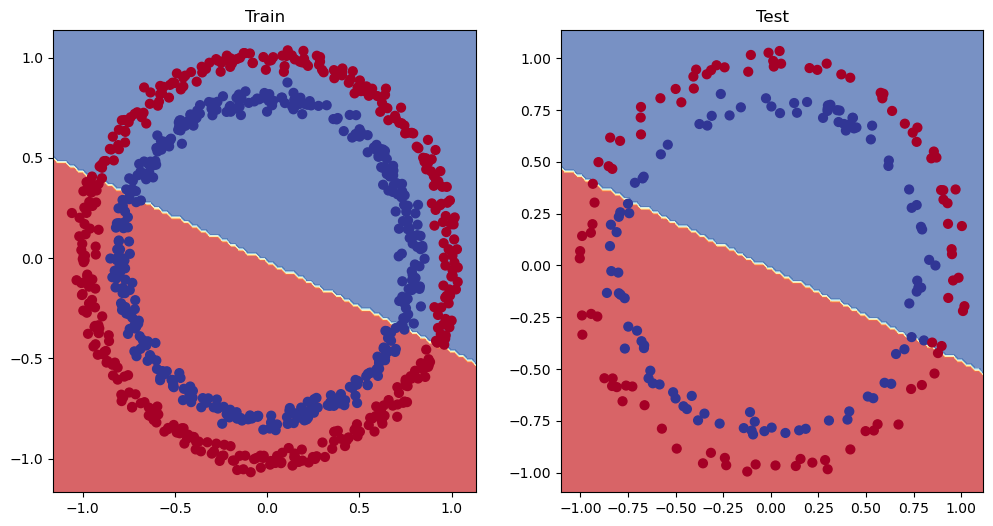

In [33]:
# Plot the decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a stright line

One way to troubleshoot a larger problem is to test out a smaller problem.

In [34]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [35]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the length of each
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

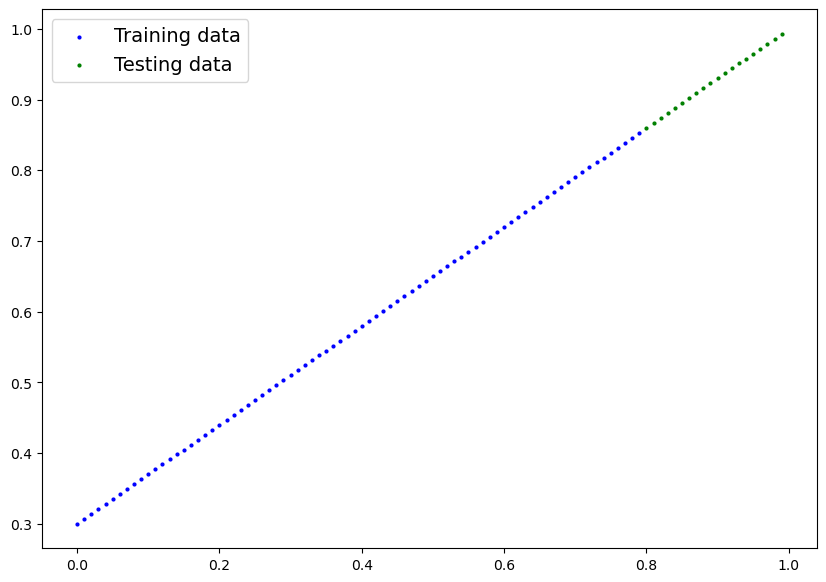

In [36]:
plot_predictions(train_data=X_train_regression, 
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

### 5.2 Adjusting `model_1` to fit a straight line

In [37]:
# Same architecture but using nn.Sequential()
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [38]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.01)

In [39]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put model to target device
model_2.to(device)

# Put data to the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)


for epoch in range(epochs):
    # Training
    model_2.train()
    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}  | Test loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.75986  | Test loss: 0.91103
Epoch: 100 | Loss: 0.02858  | Test loss: 0.00081
Epoch: 200 | Loss: 0.02533  | Test loss: 0.00209
Epoch: 300 | Loss: 0.02137  | Test loss: 0.00305
Epoch: 400 | Loss: 0.01964  | Test loss: 0.00341
Epoch: 500 | Loss: 0.01940  | Test loss: 0.00387
Epoch: 600 | Loss: 0.01903  | Test loss: 0.00379
Epoch: 700 | Loss: 0.01878  | Test loss: 0.00381
Epoch: 800 | Loss: 0.01840  | Test loss: 0.00329
Epoch: 900 | Loss: 0.01798  | Test loss: 0.00360


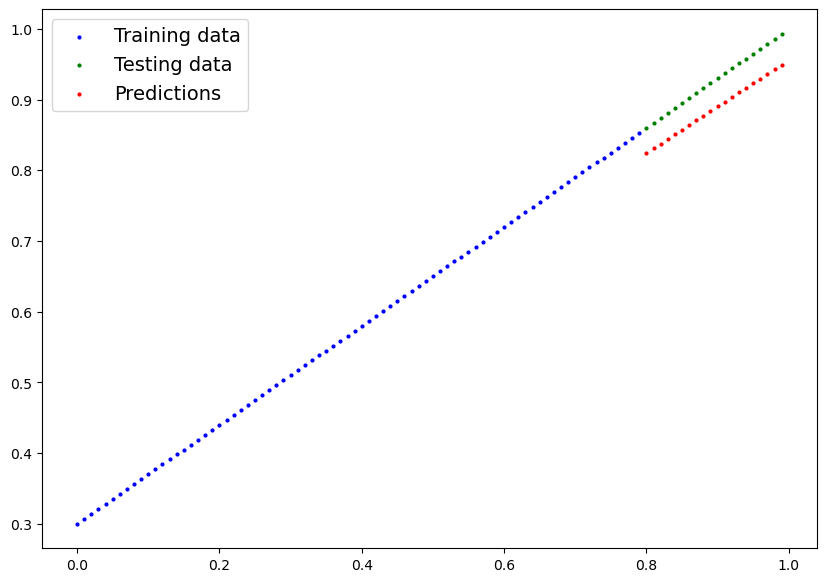

In [40]:
model_2.eval()
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu())


## 6.1 The missing piece: non-linearity

"What patterns could you draw if you were given an infinite amount of staright and non-straight lines?"

Or in machine learning terms, an infinite amount (but really it is finite) of linear and non-linear functions?

### 6.1 Recreating non-linear data (red and blue circles)

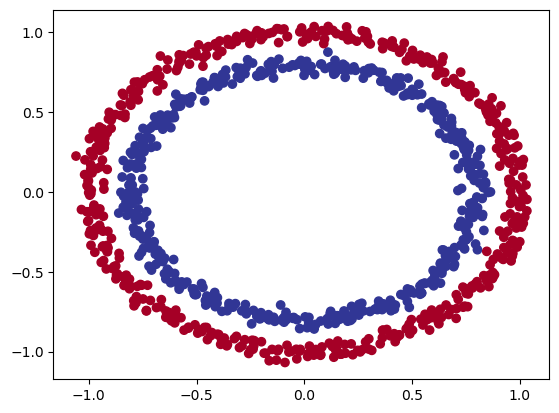

In [41]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [42]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# plit into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

In [43]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()   # relu is a non-linear activation function

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    
model_3 = CircleModelV2().to(device)
model_3


CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [44]:
# Create a loss function and optimzer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

### 6.3 Training a model with non-linearity

In [45]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 2000

# Put model to target device
model_3.to(device)

# Put data to the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_3.train()

    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Acc: 50.00% | Test loss: 0.69319, Test acc: 50.00%
Epoch: 100 | Loss: 0.69115, Acc: 52.88% | Test loss: 0.69102, Test acc: 52.50%
Epoch: 200 | Loss: 0.68977, Acc: 53.37% | Test loss: 0.68940, Test acc: 55.00%
Epoch: 300 | Loss: 0.68795, Acc: 53.00% | Test loss: 0.68723, Test acc: 56.00%
Epoch: 400 | Loss: 0.68517, Acc: 52.75% | Test loss: 0.68411, Test acc: 56.50%
Epoch: 500 | Loss: 0.68102, Acc: 52.75% | Test loss: 0.67941, Test acc: 56.50%
Epoch: 600 | Loss: 0.67515, Acc: 54.50% | Test loss: 0.67285, Test acc: 56.00%
Epoch: 700 | Loss: 0.66659, Acc: 58.38% | Test loss: 0.66322, Test acc: 59.00%
Epoch: 800 | Loss: 0.65160, Acc: 64.00% | Test loss: 0.64757, Test acc: 67.50%
Epoch: 900 | Loss: 0.62362, Acc: 74.00% | Test loss: 0.62145, Test acc: 79.00%
Epoch: 1000 | Loss: 0.56818, Acc: 87.75% | Test loss: 0.57378, Test acc: 86.50%
Epoch: 1100 | Loss: 0.48153, Acc: 93.50% | Test loss: 0.49935, Test acc: 90.50%
Epoch: 1200 | Loss: 0.37056, Acc: 97.75% | Test loss

### 6.4 Evaluating a model trained with non-linear activation functions

In [46]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

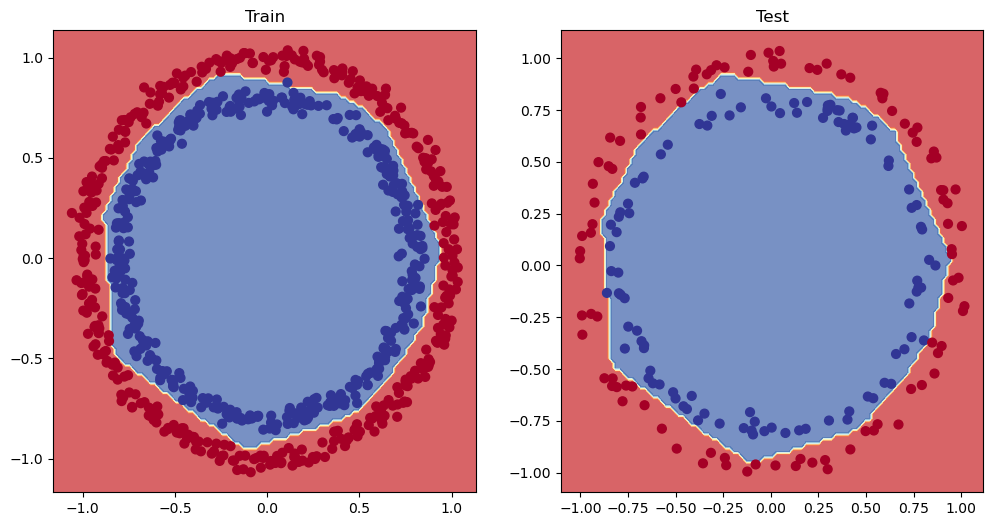

In [47]:
# Plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

**Challenge:** Can you improve model_3 to do better than 80% accuracy on the test data?

Running for 2000 epochs achieves an accuracy of 99.5%!!

## 7. Replicating non-linear activation functions

Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own.

And these tools are linear and non-linear functions.

In [48]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

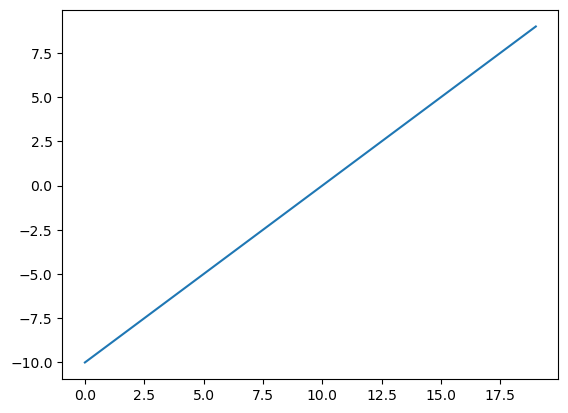

In [49]:
# Visualize the tensor
plt.plot(A)

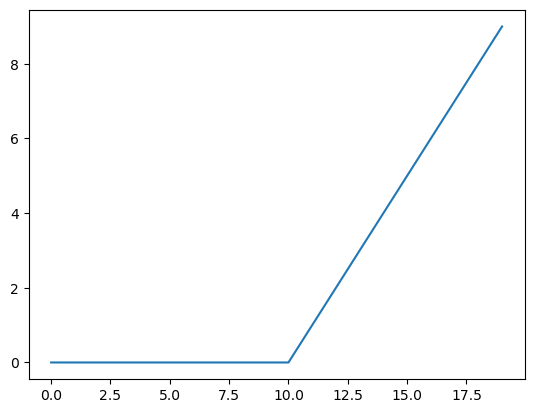

In [50]:
plt.plot(torch.relu(A))

In [51]:
def relu(x):
    return torch.maximum(torch.tensor(0), x)    # inputs must be tensors

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

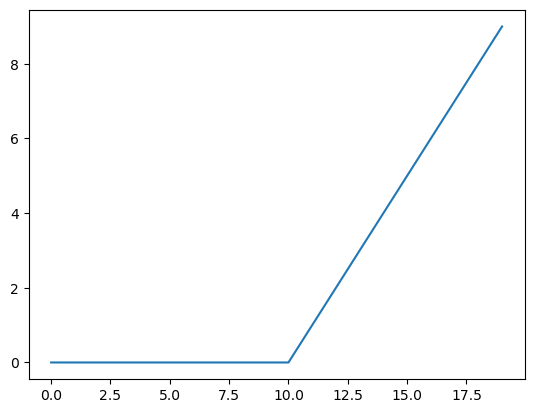

In [52]:
# Plot ReLU activation function
plt.plot(relu(A))

In [53]:
# Now let's do the same for Sigmoid
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

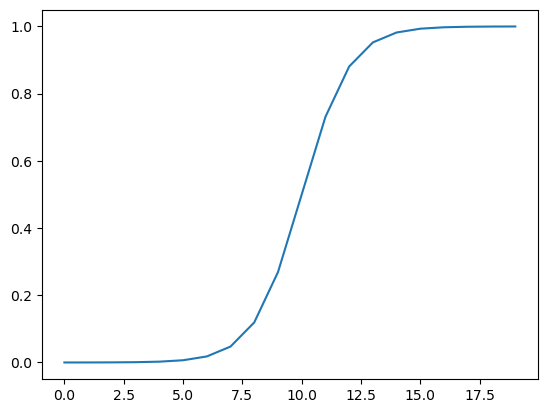

In [54]:
plt.plot(torch.sigmoid(A))

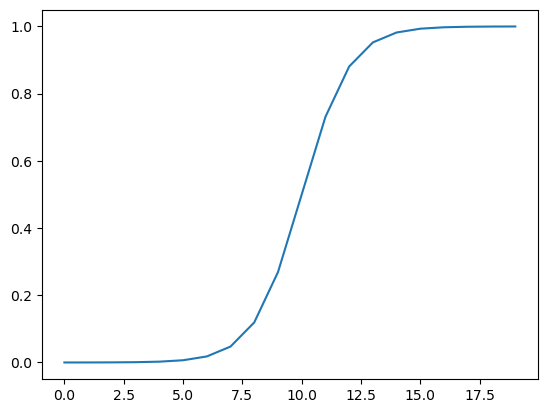

In [55]:
plt.plot(sigmoid(A))

## 8. Putting it all together with a multi-class classification problem

### 8.1 Creating our toy multi-class dataset

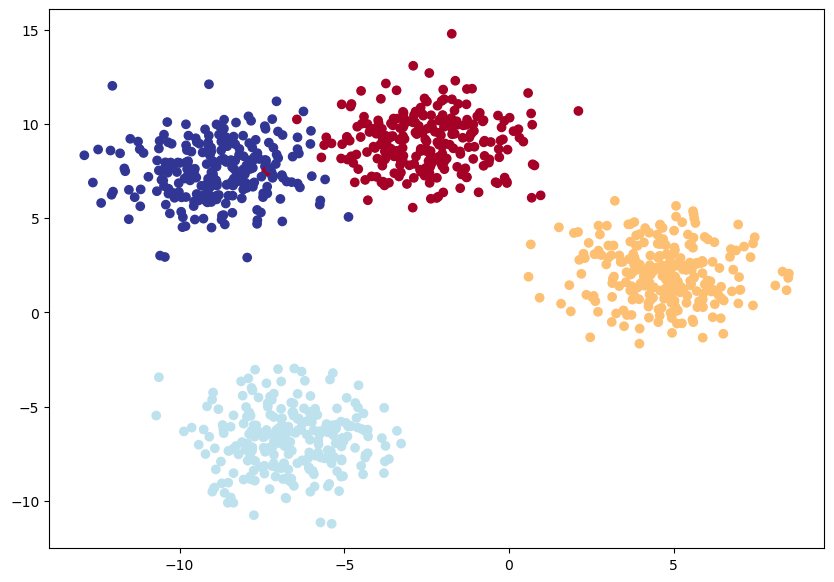

In [75]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000, 
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,                 # give the clusters a little shake up
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

### 8.2 Building a multi-class classification problem in PyTorch

In [76]:
# Creaet device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [77]:
# Build a multi-class classification model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """ Initializes multi-class classification model.
        
        Args:
            input_features (int): numer of input features to the model
            output_features (int): Numer of output features (number of Output classes)
            hidden units (int): Number of hidden units between layers, default 8
        
        Returns:

        Example:
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
           nn.Linear(in_features=input_features, out_features=hidden_units),
           nn.ReLU(),
           nn.Linear(in_features=hidden_units, out_features=hidden_units),
           nn.ReLU(),
           nn.Linear(in_features=hidden_units, out_features=output_features) 
        )

    def forward(self, x):
        return self.linear_layer_stack(x)
    
# Create an instance of BlobModel and sned it to the target device
model_4 = BlobModel(input_features=2, output_features=4, hidden_units=8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [78]:
X_blob_train.shape, y_blob_test[:5]

(torch.Size([800, 2]), tensor([1, 3, 2, 1, 0]))

In [79]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

### 8.3 Create a loss function and an optimzer for a multi-class classification problem

In [80]:
# Create a loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer for multi-class classification
optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.1)

### 8.4 Getting prediction probabilities for a multi-class PyTorch model

In order to evaluate and train and test our model, we need to convert our model's outputs (logits) to prediction probabilities and then to prediction lebls.

Logits (raw output of the model) -> Pred probs (use `torch.softmax`) -> Pred labels (take the argmax of the prediction probablities)

In [81]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[ 0.7111, -0.5330,  0.3307, -0.2327],
        [-0.3420, -1.7850, -0.3224, -1.1384],
        [ 0.1878, -0.8563,  0.3375, -0.9026],
        [ 0.4513, -0.4277,  0.2498, -0.1940],
        [ 0.8922, -0.9492,  0.3245, -0.5287],
        [-0.4885, -2.0119, -0.4004, -1.3252],
        [ 0.2586, -0.8477,  0.2739, -0.8695],
        [ 0.6816, -1.1144,  0.2053, -0.6434],
        [ 0.3433, -1.0156,  0.4706, -1.1226],
        [ 0.7687, -1.0243,  0.2629, -0.5887]], device='cuda:0')

In [82]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [83]:
# Convert our model's logits to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.7111, -0.5330,  0.3307, -0.2327],
        [-0.3420, -1.7850, -0.3224, -1.1384],
        [ 0.1878, -0.8563,  0.3375, -0.9026],
        [ 0.4513, -0.4277,  0.2498, -0.1940],
        [ 0.8922, -0.9492,  0.3245, -0.5287]], device='cuda:0')
tensor([[0.4236, 0.1221, 0.2895, 0.1648],
        [0.3694, 0.0873, 0.3767, 0.1666],
        [0.3509, 0.1235, 0.4076, 0.1179],
        [0.3627, 0.1506, 0.2965, 0.1902],
        [0.5084, 0.0806, 0.2882, 0.1228]], device='cuda:0')


In [84]:
# Convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([0, 2, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2,
        2, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0,
        2, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2,
        0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2,
        2, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
        2, 2, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0,
        2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2, 2, 0, 0,
        0, 2, 2, 0, 2, 0, 2, 0], device='cuda:0')

In [85]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

### 8.5 Create a training loop and testing loop for a multi-class PyTorch model

In [86]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put model to target device
model_4.to(device)

# Put data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # turn logits -> pred probs -> pred labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.37484, Acc: 49.38% | Test loss: 1.14556, Test acc: 76.50%
Epoch: 10 | Loss: 0.66512, Acc: 72.62% | Test loss: 0.55919, Test acc: 79.50%
Epoch: 20 | Loss: 0.50131, Acc: 73.12% | Test loss: 0.41657, Test acc: 79.00%
Epoch: 30 | Loss: 0.40910, Acc: 80.75% | Test loss: 0.33745, Test acc: 84.00%
Epoch: 40 | Loss: 0.33915, Acc: 87.00% | Test loss: 0.27875, Test acc: 90.00%
Epoch: 50 | Loss: 0.26286, Acc: 94.88% | Test loss: 0.21292, Test acc: 97.00%
Epoch: 60 | Loss: 0.16298, Acc: 98.38% | Test loss: 0.13005, Test acc: 99.00%
Epoch: 70 | Loss: 0.09657, Acc: 98.88% | Test loss: 0.07737, Test acc: 99.00%
Epoch: 80 | Loss: 0.06813, Acc: 98.88% | Test loss: 0.05467, Test acc: 99.00%
Epoch: 90 | Loss: 0.05487, Acc: 98.88% | Test loss: 0.04399, Test acc: 99.00%


### 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [87]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

y_logits[:10]

tensor([[ 0.9988,  4.9449, -2.3442, -0.9238],
        [-1.5220, -6.5819, -8.1528,  3.7136],
        [-3.8011, -3.0290,  5.1995, -2.5184],
        [-0.1409,  3.5777, -1.3611, -0.3910],
        [ 6.0244,  2.6601, -5.1481, -1.9724],
        [-2.2247, -8.1695, -9.5303,  4.6788],
        [-3.5962, -2.8465,  4.8426, -2.3268],
        [ 5.0665, -0.2089, -6.0726, -0.7773],
        [-4.3616, -3.6295,  6.2815, -3.1414],
        [ 5.3172,  0.8219, -5.6387, -1.1980]], device='cuda:0')

In [88]:
# Go from logits -> prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[1.8898e-02, 9.7767e-01, 6.6765e-04, 2.7632e-03],
        [5.2952e-03, 3.3604e-05, 6.9853e-06, 9.9466e-01],
        [1.2323e-04, 2.6672e-04, 9.9917e-01, 4.4439e-04],
        [2.3105e-02, 9.5208e-01, 6.8199e-03, 1.7993e-02],
        [9.6624e-01, 3.3418e-02, 1.3581e-05, 3.2516e-04],
        [1.0033e-03, 2.6281e-06, 6.7393e-07, 9.9899e-01],
        [2.1600e-04, 4.5710e-04, 9.9856e-01, 7.6869e-04],
        [9.9204e-01, 5.0754e-03, 1.4417e-05, 2.8748e-03],
        [2.3862e-05, 4.9617e-05, 9.9985e-01, 8.0838e-05],
        [9.8750e-01, 1.1022e-02, 1.7237e-05, 1.4623e-03]], device='cuda:0')

In [89]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

In [90]:
# Go from pred probs to pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

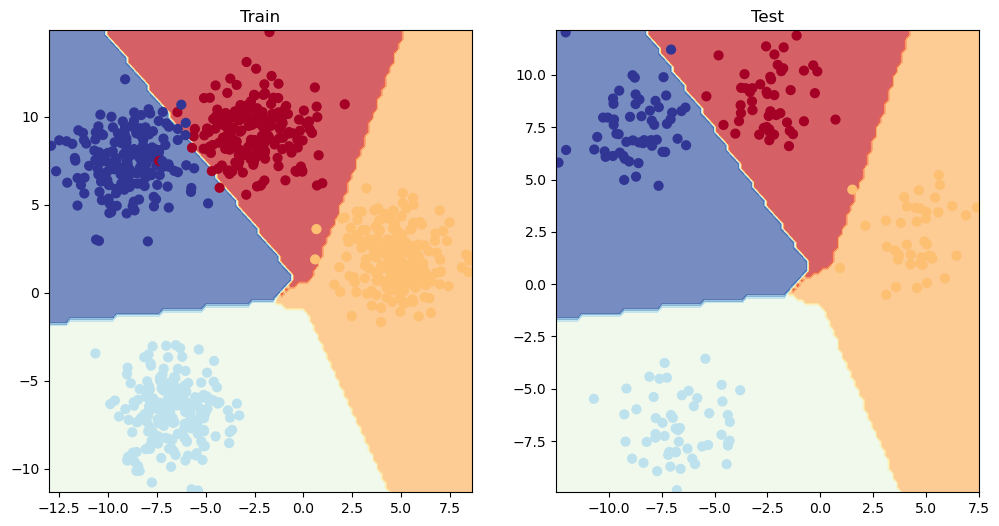

In [91]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. A few more classigication metrics... (to evaluate our classification model)

* Accuracy - out of 100 samples, how many does our model get right?
* Precision
* Recall
* F1-score
* Confusion matrix
* Classification report

 See this article for when to use precision/recall - https://willkoehrsen.github.io/statistics/learning/beyond-accuracy-precision-and-recall/

 If you want to access a lot of PyTorch metric, see TorchMetrics - https://torchmetrics.readthedocs.io/en/stable/

In [97]:
from torchmetrics import Accuracy

# Setup metric
torchmetric_accuracy = Accuracy(task="multiclass", num_classes=4).to(device)

# Calculate accuracy
torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.9900, device='cuda:0')